# نصب کتابخانه‌های مورد نیاز (اگر نصب نشده‌اند)
try:
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
    from ultralytics import YOLO
except ImportError:
    print("Installing segment-anything and ultralytics libraries...")
    !pip install git+https://github.com/facebookresearch/segment-anything.git
    !pip install ultralytics
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
    from ultralytics import YOLO

try:
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
except ImportError:
    print("در حال نصب کتابخانه segment-anything...")
    !pip install git+https://github.com/facebookresearch/segment-anything.git
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

pip install segment_anything 

pip install huggingface_hub

pip install segmentation-models

pip install --upgrade jupyter ipywidgets

## deepleb

In [3]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import cv2
import os
from pathlib import Path
import gc
import time
import requests
from io import BytesIO

# ================== Main Configuration ==================

# --- Folder Paths ---
ROOT_DIR = Path(__file__).parent if "__file__" in globals() else Path.cwd()
INPUT_FOLDER = ROOT_DIR / "images" / "input"
OUTPUT_FOLDER = ROOT_DIR / "images" / "deeplab_segmented"
MODEL_DOWNLOAD_DIR = ROOT_DIR / "download_model"

# --- Optimization Settings ---
# Default to the heavier model for the highest quality. Set to True for faster processing.
USE_LIGHTER_MODEL = False
RESIZE_IMAGES = True      # Resize images for faster processing
MAX_IMAGE_SIZE = 1024     # Max image dimension (width or height) in pixels
SHOW_PLOTS = False        # Set to True to display matplotlib plots (disables for batch processing)
CLEAR_MEMORY = True       # Free up memory after processing each image

# --- Device Setup (GPU or CPU) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ================== Core Functions ==================

def download_file(url: str, dest_path: Path):
    """Downloads a file with a progress bar."""
    print(f"Downloading from: {url}")
    try:
        response = requests.get(url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 * 8
        
        with open(dest_path, 'wb') as f:
            downloaded = 0
            for chunk in response.iter_content(chunk_size=block_size):
                downloaded += len(chunk)
                f.write(chunk)
                # Simple progress display
                done = int(50 * downloaded / total_size) if total_size > 0 else 0
                print(f"\r  [{'=' * done}{' ' * (50-done)}] {downloaded / (1024*1024):.2f}MB", end='')
        print("\nDownload complete.")
    except requests.exceptions.RequestException as e:
        print(f"\n❌ Error downloading file: {e}")
        if dest_path.exists():
            dest_path.unlink() # Remove partial file
        raise

def load_segmentation_model(model_name=None):
    """
    Loads a segmentation model, downloading it to a local folder if it doesn't exist.
    """
    if model_name is None:
        model_name = "deeplabv3_mobilenet_v3_large" if USE_LIGHTER_MODEL else "deeplabv3_resnet101"

    print(f"🚀 Loading the powerful {model_name} model...")

    model_map = {
        "deeplabv3_resnet101": torchvision.models.segmentation.deeplabv3_resnet101,
        "deeplabv3_resnet50": torchvision.models.segmentation.deeplabv3_resnet50,
        "deeplabv3_mobilenet_v3_large": torchvision.models.segmentation.deeplabv3_mobilenet_v3_large,
    }
    weights_map = {
        "deeplabv3_resnet101": torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT,
        "deeplabv3_resnet50": torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT,
        "deeplabv3_mobilenet_v3_large": torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT,
    }

    if model_name not in model_map:
        raise ValueError(f"Model '{model_name}' is not supported.")

    try:
        weights_enum = weights_map[model_name]
        
        # --- Local Model File Management ---
        model_url = weights_enum.url
        model_filename = Path(model_url).name
        local_model_path = MODEL_DOWNLOAD_DIR / model_filename

        if not local_model_path.is_file():
            print(f"Model not found at {local_model_path}.")
            download_file(model_url, local_model_path)
        else:
            print(f"Found model locally: {local_model_path}")

        # --- THE FIX IS HERE ---
        # 1. `pretrained_backbone=False` stops the unwanted second download.
        # 2. `aux_loss=True` creates the model with the correct structure to match the loaded weights.
        model = model_map[model_name](
            weights=None,
            pretrained_backbone=False,
            aux_loss=True
        )
        
        # Now, load the weights from our local file into the correctly structured model
        model.load_state_dict(torch.load(local_model_path))
        
        classes = weights_enum.meta["categories"]
        preprocess = weights_enum.transforms()

        model.to(device).eval()

        print(f"✅ Model {model_name} with {len(classes)} classes loaded successfully.")
        return model, preprocess, ['__background__'] + classes

    except Exception as e:
        print(f"❌ Error during model loading: {e}")
        raise
    
def create_color_palette(num_classes):
    """Creates a color palette for visualizing different classes."""
    np.random.seed(42)
    palette = np.random.randint(0, 256, size=(num_classes, 3), dtype=np.uint8)
    palette[0] = [0, 0, 0]  # Background class is always black
    return palette

def resize_image(img, max_size=MAX_IMAGE_SIZE):
    """Resizes an image while maintaining its aspect ratio."""
    if not RESIZE_IMAGES or max(img.size) <= max_size:
        return img
    scale = max_size / max(img.size)
    new_size = (int(img.width * scale), int(img.height * scale))
    return img.resize(new_size, Image.Resampling.LANCZOS)

def segment_image(model, preprocess, image_path, classes, confidence_threshold=0.5, alpha=0.5):
    """Processes and segments a single image."""
    try:
        if str(image_path).startswith(('http://', 'https://')):
            response = requests.get(str(image_path))
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path).convert('RGB')

        resized_img = resize_image(img)
        img_tensor = preprocess(resized_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)["out"]

        normalized_masks = torch.nn.functional.softmax(output, dim=1)
        confidence, pred = torch.max(normalized_masks, 1)

        pred_np = pred.squeeze().cpu().numpy()
        confidence_np = confidence.squeeze().cpu().numpy()
        palette = create_color_palette(len(classes))
        color_mask = np.zeros((pred_np.shape[0], pred_np.shape[1], 3), dtype=np.uint8)

        active_classes = {}
        for class_idx in range(1, len(classes)):
            mask = (pred_np == class_idx) & (confidence_np >= confidence_threshold)
            if mask.any():
                percentage = mask.sum() / mask.size * 100
                active_classes[classes[class_idx]] = percentage
                color_mask[mask] = palette[class_idx]

        resized_img_np = np.array(resized_img)
        if resized_img_np.shape[:2] != color_mask.shape[:2]:
            color_mask = cv2.resize(color_mask, (resized_img_np.shape[1], resized_img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

        overlay = cv2.addWeighted(resized_img_np, 1, color_mask, alpha, 0)
        
        if img.size != resized_img.size:
            overlay_original = cv2.resize(overlay, (img.width, img.height), interpolation=cv2.INTER_LINEAR)
        else:
            overlay_original = overlay

        return np.array(img), overlay_original, active_classes

    except Exception as e:
        print(f"❌ Error processing image {Path(image_path).name}: {e}")
        return None, None, {}

def save_results(overlay, active_classes, output_path_prefix):
    """Saves the segmentation results."""
    try:
        # Save the overlay image
        cv2.imwrite(f"{output_path_prefix}_overlay.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        
        # Save the detected classes info to a text file
        info_path = f"{output_path_prefix}_info.txt"
        with open(info_path, 'w', encoding='utf-8') as f:
            f.write("Detected Classes:\n")
            if not active_classes:
                f.write("None\n")
            else:
                for cls, pct in sorted(active_classes.items(), key=lambda x: x[1], reverse=True):
                    f.write(f"- {cls}: {pct:.2f}%\n")
        return True
    except Exception as e:
        print(f"❌ Error saving results: {e}")
        return False

def clear_memory_fn():
    """Frees up memory to prevent leakage, especially on GPU."""
    if CLEAR_MEMORY:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ================== Main Execution Logic ==================

def batch_process_images(model, preprocess, classes, confidence_threshold=0.5, alpha=0.5):
    """Processes all valid images in a given folder."""
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
    image_files = [p for p in INPUT_FOLDER.iterdir() if p.is_file() and p.suffix.lower() in valid_extensions]

    if not image_files:
        print(f"⚠️ No images found in '{INPUT_FOLDER}'.")
        return

    print(f"\nFound {len(image_files)} image(s). Starting batch process...")
    start_time = time.time()

    for i, img_path in enumerate(image_files):
        print(f"  ({i+1}/{len(image_files)}) Processing: {img_path.name}")
        
        img, overlay, active_classes = segment_image(
            model, preprocess, img_path, classes,
            confidence_threshold=confidence_threshold, alpha=alpha
        )

        if img is None:
            continue

        output_path_prefix = OUTPUT_FOLDER / img_path.stem
        if save_results(overlay, active_classes, str(output_path_prefix)):
            print(f"  ✅ Results for {img_path.name} saved to '{OUTPUT_FOLDER}'.")

        clear_memory_fn()

    total_time = time.time() - start_time
    print(f"\n🎉 Batch processing finished in {total_time:.2f} seconds.")
    print(f"Average time per image: {total_time / len(image_files):.2f} seconds.")


def main():
    """Main function to run the application."""
    try:
        # --- Create Folders ---
        INPUT_FOLDER.mkdir(parents=True, exist_ok=True)
        OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
        MODEL_DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)
        
        print(f"✅ Using device: {device}")
        
        model, preprocess, classes = load_segmentation_model()
        batch_process_images(
            model, preprocess, classes,
            confidence_threshold=0.5,  # Confidence threshold for detection (adjustable)
            alpha=0.6                  # Alpha for overlay transparency (adjustable)
        )
    except Exception as e:
        print(f"❌ A critical error occurred: {e}")

if __name__ == "__main__":
    main()

✅ Using device: cuda
🚀 Loading the powerful deeplabv3_resnet101 model...
Found model locally: d:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\download_model\deeplabv3_resnet101_coco-586e9e4e.pth


c:\ProgramData\anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=None`.
  warnings.warn(msg)
C:\Users\AERO\AppData\Local\Temp\ipykernel_17420\1891464835.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release

✅ Model deeplabv3_resnet101 with 21 classes loaded successfully.

Found 7 image(s). Starting batch process...
  (1/7) Processing: festive-holiday-gathering-with-friends-340661.jpg
  ✅ Results for festive-holiday-gathering-with-friends-340661.jpg saved to 'd:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\deeplab_segmented'.
  (2/7) Processing: high-speed-racing-spectacle-6136403.jpg
  ✅ Results for high-speed-racing-spectacle-6136403.jpg saved to 'd:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\deeplab_segmented'.
  (3/7) Processing: john-matychuk-yvfp5YHWGsc-unsplash.jpg
  ✅ Results for john-matychuk-yvfp5YHWGsc-unsplash.jpg saved to 'd:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\deeplab_segmented'.
  (4/7) Processing: playful-donkeys-in-a-pastoral-setting-101222214.jpg
  ✅ Results for playful-donkeys-in-a-pastoral-setting-101222214.jpg saved to 'd:\back\projects_and_portfolio\Deep Learning\04

## more power SAM (Segment Anything Model)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import os, gc, time, requests, numpy as np, torch, cv2
from pathlib import Path
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from typing import Optional, List, Dict
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# ================== Settings ==================
SHOW_PLOTS = False
CLEAR_MEMORY = True
device = torch.device('cpu')  # change to 'cuda' if you have enough VRAM
MODEL_TYPE = "vit_h"          # "vit_h" or "vit_b"

# ---- NEW: Export/Label settings ----
DRAW_IDS = True               # draw numeric IDs + labels on boundary image
EXPORT_CSV = True             # write *_segments.csv
EXPORT_TXT = True             # write *_segments.txt
ENABLE_SEMANTIC_LABELS = True # try to produce meaningful labels
MAX_LABEL_CHARS = 24

# Keep original image size by default
RESIZE_FOR_SAM = False
RESIZE_LONG_SIDE = 768

# Default candidate labels (overridden by ./labels.txt if present)
DEFAULT_LABEL_CANDIDATES = [
    # People & Anatomy
    "person", "man", "woman", "child", "face", "eye", "hair", "hand", "foot", "leg", "arm",
    # Animals
    "dog", "cat", "bird", "horse", "cow", "sheep",
    # Food & Drink
    "food", "fruit", "vegetable", "apple", "banana", "orange", "cake", "bread", "sandwich",
    "plate", "bowl", "cup", "glass", "bottle", "fork", "spoon", "knife", "candle",
    # Furniture & Household
    "chair", "table", "couch", "bed", "desk", "door", "window", "lamp", "vase", "clock", "book",
    "potted plant", "flower", "refrigerator", "sink", "toilet",
    # Clothing & Accessories
    "hat", "shirt", "pants", "shoe", "bag", "backpack", "suitcase", "umbrella", "watch", "glasses",
    # Electronics
    "phone", "laptop", "computer monitor", "keyboard", "mouse", "remote control", "television",
    # Vehicles
    "car", "truck", "bus", "bicycle", "motorcycle", "boat", "airplane",
    # Outdoor & Nature
    "tree", "building", "house", "road", "sidewalk", "sky", "cloud", "mountain", "rock", "water","star"
]

# Paths
ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path(".").resolve()
INPUT_FOLDER = ROOT / "images" / "input"
OUTPUT_FOLDER = ROOT / "images" / "segmented"
MODEL_DIR = ROOT / "download_model"

# Model registry (filename + official URL)
MODEL_INFO = {
    "vit_h": {
        "filename": "sam_vit_h_4b8939.pth",
        "url": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
        "min_bytes": 2_400_000_000
    },
    "vit_b": {
        "filename": "sam_vit_b_01ec64.pth",
        "url": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        "min_bytes": 300_000_000
    },
}

# Create folders
INPUT_FOLDER.mkdir(parents=True, exist_ok=True)
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ================== Housekeeping ==================
def clear_memory():
    if CLEAR_MEMORY:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ================== Download utils ==================
def safe_download(url: str, dst_path: Path):
    head = requests.head(url, timeout=60)
    head.raise_for_status()
    total = int(head.headers.get("content-length", "0"))

    local = dst_path.stat().st_size if dst_path.exists() else 0
    if total and local == total:
        print(f"✔️ Model already complete: {dst_path}")
        return
    if total and local > total:
        dst_path.unlink(missing_ok=True)
        local = 0

    headers = {"Range": f"bytes={local}-"} if local else {}
    mode = "ab" if local else "wb"
    print("⬇️ Downloading model...")

    with requests.get(url, stream=True, headers=headers, timeout=120) as r:
        if r.status_code == 200 and local:
            mode = "wb"
            local = 0
        r.raise_for_status()
        done = local
        block = 1024 * 1024
        with open(dst_path, mode) as f:
            for chunk in r.iter_content(block):
                if not chunk:
                    continue
                f.write(chunk)
                done += len(chunk)
                if total:
                    pct = done * 100 / total
                    print(f"\rدانلود: {pct:.1f}% ({done/(1024*1024):.1f} MB / {total/(1024*1024):.1f} MB)", end="")
    print("\n✔️ Model downloaded.")

def ensure_model_ready(model_type: str) -> str:
    info = MODEL_INFO[model_type]
    dst = MODEL_DIR / info["filename"]
    if dst.exists() and dst.stat().st_size >= info["min_bytes"]:
        print("✔️ Model found:", dst)
        return str(dst)
    safe_download(info["url"], dst)
    if not dst.exists() or dst.stat().st_size < info["min_bytes"]:
        raise RuntimeError("Downloaded model seems incomplete or corrupted.")
    return str(dst)

# ================== SAM loader ==================
def load_sam_model(model_path: str, model_type: str):
    print(f"Loading SAM ({model_type}) on {device} ...")
    sam = sam_model_registry[model_type](checkpoint=model_path)
    sam.to(device=device)
    sam.eval()
    mask_gen = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,
        points_per_batch=32,
        pred_iou_thresh=0.90,
        stability_score_thresh=0.95,
        crop_n_layers=0,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=300
    )
    return mask_gen

# ================== Image I/O ==================
def _resize_long_side(img: np.ndarray, max_side: int = 768):
    h, w = img.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return img, 1.0
    scale = max_side / m
    nh, nw = int(h * scale), int(w * scale)
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA), scale

def load_image(image_path: Path) -> Optional[np.ndarray]:
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Cannot open image: {image_path}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print("Image load error:", e)
        return None

# ================== Viz/Save ==================
def create_color_segmentation(img: np.ndarray, masks: List[Dict]):
    h, w = img.shape[:2]
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    overlay = img.copy()
    boundary_img = img.copy()
    rng = np.random.default_rng(42)
    for m in masks:
        seg = m["segmentation"].astype(bool)
        color = rng.integers(0, 255, size=3, dtype=np.uint8)
        color_mask[seg] = color
        alpha = 0.35
        overlay[seg] = (overlay[seg] * (1 - alpha) + color * alpha).astype(np.uint8)
        cnts, _ = cv2.findContours(seg.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(boundary_img, cnts, -1, (255, 0, 0), 1)
    return color_mask, overlay, boundary_img

def save_results(img, cm, ov, bd, out_prefix: Path):
    out_prefix = str(out_prefix)
    cv2.imwrite(out_prefix + "_original.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out_prefix + "_mask.png", cv2.cvtColor(cm, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out_prefix + "_overlay.png", cv2.cvtColor(ov, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out_prefix + "_boundary.png", cv2.cvtColor(bd, cv2.COLOR_RGB2BGR))
    print(f"✅ Saved: {out_prefix}_*.png")

# ---- Mask props, labeling, and drawing IDs ----
def _mask_props(m: Dict) -> Dict:
    area = int(m.get("area", int(np.sum(m["segmentation"]))))
    bbox = m.get("bbox", None)  # [x, y, w, h]
    piou = float(m.get("predicted_iou", np.nan))
    stab = float(m.get("stability_score", np.nan))
    return {"area": area, "bbox": bbox, "pred_iou": piou, "stability_score": stab}

def _mask_centroid(seg: np.ndarray) -> tuple:
    ys, xs = np.where(seg)
    if len(xs) == 0:
        return (0, 0)
    cx, cy = int(xs.mean()), int(ys.mean())
    return (cx, cy)

def _annotate_ids(boundary_img: np.ndarray, masks: List[Dict], labels: Optional[List[str]] = None) -> np.ndarray:
    img = boundary_img.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, m in enumerate(masks, start=1):
        seg = m["segmentation"].astype(bool)
        x, y = _mask_centroid(seg)
        text = f"{i}"
        if labels is not None and i-1 < len(labels) and labels[i-1]:
            lab = labels[i-1][:MAX_LABEL_CHARS]
            text = f"{i}:{lab}"
        cv2.putText(img, text, (max(0, x-5), max(14, y)), font, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
    return img

def _write_csv_txt(out_prefix: Path, rows: List[Dict]):
    import csv
    base = str(out_prefix)
    if EXPORT_CSV and rows:
        with open(base + "_segments.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
            writer.writeheader()
            writer.writerows(rows)
    if EXPORT_TXT and rows:
        with open(base + "_segments.txt", "w", encoding="utf-8") as f:
            for r in rows:
                f.write(
                    f'ID:{r["id"]} area:{r["area_px"]} bbox:{r["bbox"]} '
                    f'pred_iou:{r["predicted_iou"]:.3f} stability:{r["stability_score"]:.3f} '
                    f'label:{r.get("label","")}\n'
                )

# ---------- SEMANTIC LABELING (CLIP zero-shot -> fallback to ImageNet) ----------
_label_candidates: List[str] = []
_clip_model = None
_clip_preprocess = None
_clip_device = "cpu"
_image_classifier = None

def _load_label_candidates() -> List[str]:
    path = ROOT / "labels.txt"
    if path.exists():
        txt = path.read_text(encoding="utf-8").splitlines()
        return [t.strip() for t in txt if t.strip()]
    return list(DEFAULT_LABEL_CANDIDATES)

def _init_clip() -> bool:
    global _clip_model, _clip_preprocess, _clip_device
    if _clip_model is not None:
        return True
    try:
        import clip  # openai/CLIP
        _clip_device = "cuda" if torch.cuda.is_available() else "cpu"
        _clip_model, _clip_preprocess = clip.load("ViT-B/32", device=_clip_device, jit=False)
        return True
    except Exception:
        return False

def _clip_zeroshot_label(crop_rgb: np.ndarray, candidates: List[str]) -> str:
    try:
        import clip
        if _clip_model is None or _clip_preprocess is None:
            if not _init_clip():
                return ""
        pil = Image.fromarray(crop_rgb)
        image = _clip_preprocess(pil).unsqueeze(0).to(_clip_device)
        with torch.no_grad():
            text = clip.tokenize(candidates).to(_clip_device)
            image_features = _clip_model.encode_image(image)
            text_features = _clip_model.encode_text(text)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            probs = similarity[0].detach().cpu().numpy()
            idx = int(np.argmax(probs))
            if len(candidates) and probs[idx] > 0.15:
                return f"{candidates[idx]}"
    except Exception:
        pass
    return ""

def _init_fallback_classifier() -> bool:
    global _image_classifier
    if _image_classifier is not None:
        return True
    try:
        from transformers import pipeline
        _image_classifier = pipeline("image-classification", model="google/vit-base-patch16-224")
        return True
    except Exception:
        return False

def _fallback_label(crop_rgb: np.ndarray) -> str:
    try:
        if _image_classifier is None and not _init_fallback_classifier():
            return ""
        pil = Image.fromarray(crop_rgb)
        out = _image_classifier(pil, top_k=1)
        if isinstance(out, list) and out and "label" in out[0]:
            return str(out[0]["label"])
    except Exception:
        pass
    return ""

def _predict_semantic_label(crop_rgb: np.ndarray, candidates: List[str]) -> str:
    lbl = _clip_zeroshot_label(crop_rgb, candidates)
    if lbl:
        return lbl
    return _fallback_label(crop_rgb)

# ================== Core ==================
def segment_file(mask_generator, image_path: Path):
    img = load_image(image_path)
    if img is None:
        return

    # keep original size by default
    if RESIZE_FOR_SAM:
        img_small, scale = _resize_long_side(img, max_side=RESIZE_LONG_SIDE)
    else:
        img_small, scale = img, 1.0

    t0 = time.time()
    with torch.no_grad():
        masks = mask_generator.generate(img_small)
    print(f"{image_path.name}: {len(masks)} masks in {time.time() - t0:.2f}s")

    # If resized for speed, upscale masks back
    if scale != 1.0:
        for m in masks:
            m["segmentation"] = cv2.resize(
                m["segmentation"].astype(np.uint8),
                (img.shape[1], img.shape[0]),
                interpolation=cv2.INTER_NEAREST
            ).astype(bool)
            if "bbox" in m and m["bbox"] is not None:
                inv = 1.0 / scale
                x, y, w, h = m["bbox"]
                m["bbox"] = [int(x * inv), int(y * inv), int(w * inv), int(h * inv)]

    cm, ov, bd = create_color_segmentation(img, masks)
    out_prefix = OUTPUT_FOLDER / image_path.stem
    save_results(img, cm, ov, bd, out_prefix)

    # Per-mask table + annotated IDs image with labels
    rows: List[Dict] = []
    labels: List[str] = []
    H, W = img.shape[:2]
    candidates = _load_label_candidates() if ENABLE_SEMANTIC_LABELS else []

    for i, m in enumerate(masks, start=1):
        props = _mask_props(m)
        bbox = props["bbox"]
        if bbox is None:
            ys, xs = np.where(m["segmentation"])
            if len(xs):
                x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
                bbox = [int(x0), int(y0), int(x1 - x0 + 1), int(y1 - y0 + 1)]
            else:
                bbox = [0, 0, 0, 0]

        label = ""
        if ENABLE_SEMANTIC_LABELS and bbox[2] > 0 and bbox[3] > 0:
            x, y, w, h = bbox
            x1, y1 = min(x + w, W), min(y + h, H)
            crop = img[y:y1, x:x1, :]
            if crop.size > 0:
                label = _predict_semantic_label(crop, candidates)

        labels.append(label)
        rows.append({
            "id": i,
            "area_px": props["area"],
            "bbox": bbox,
            "predicted_iou": props["pred_iou"],
            "stability_score": props["stability_score"],
            "label": label
        })

    if DRAW_IDS:
        bd_ids = _annotate_ids(bd, masks, labels=labels)
        cv2.imwrite(str(out_prefix) + "_boundary_ids.png", cv2.cvtColor(bd_ids, cv2.COLOR_RGB2BGR))

    if rows:
        _write_csv_txt(out_prefix, rows)

    clear_memory()

def main():
    model_path = ensure_model_ready(MODEL_TYPE)
    mask_gen = load_sam_model(model_path, MODEL_TYPE)

    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    files = [p for p in INPUT_FOLDER.iterdir() if p.suffix.lower() in valid_ext]
    if not files:
        print(f"No images found in: {INPUT_FOLDER}")
        return

    print(f"Processing {len(files)} images from {INPUT_FOLDER} ...")
    for p in files:
        segment_file(mask_gen, p)
    print("All done.")

if __name__ == "__main__":
    main()


✔️ Model found: D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\download_model\sam_vit_h_4b8939.pth
Loading SAM (vit_h) on cpu ...
Processing 6 images from D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\input ...
festive-holiday-gathering-with-friends-340661.jpg: 88 masks in 53.48s
✅ Saved: D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\segmented\festive-holiday-gathering-with-friends-340661_*.png
high-speed-racing-spectacle-6136403.jpg: 69 masks in 29.93s
✅ Saved: D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\segmented\high-speed-racing-spectacle-6136403_*.png
john-matychuk-yvfp5YHWGsc-unsplash.jpg: 33 masks in 81.11s
✅ Saved: D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\segmented\john-matychuk-yvfp5YHWGsc-unsplash_*.png
rafael-de-nadai-CelTm7ss3Ho-unsplash.jpg: 31 masks in 53.20s
✅ Saved: D:\back\projects_and_portfolio\Deep Learnin

# سبک تر با MobileSAM

SDPA backend: math (new API)
✔ Found: sam_vit_h_4b8939.pth
Using official SAM: vit_h
Processing sample image ...
Generated 50 masks in 146.50s
Saved: D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\segmented\truck_*.png


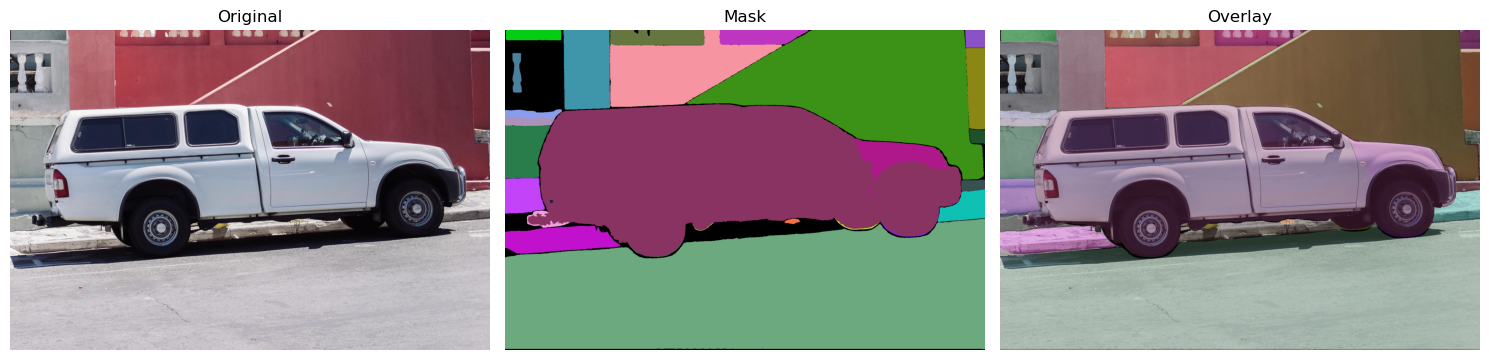

Processing local images ...


KeyboardInterrupt: 

In [4]:
import os, gc, time, requests, numpy as np, torch, cv2
from pathlib import Path
from typing import Optional, List, Dict, Tuple
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# ================== Switches ==================
USE_MOBILE_SAM = False           # False -> use official SAM (vit_h -> vit_b fallback). True -> use MobileSAM (vit_t)
SHOW_PLOTS = True
CLEAR_MEMORY = True
ENABLE_SEMANTIC_LABELS = True    # needs clip or transformers installed (optional)
DRAW_IDS = True
EXPORT_CSV = True
EXPORT_TXT = True

# Keep original size by default (set True to speed up with a small resize)
RESIZE_IMAGES = False
MAX_IMAGE_SIZE = 1024

# Device
# ---- Force SDPA math backend on CUDA to avoid NotImplementedError ----
if torch.cuda.is_available():
    # allow TF32 (a bit faster on Ampere+)
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    except Exception:
        pass

    # PyTorch >= 2.1 style
    try:
        torch.backends.cuda.enable_flash_sdp(False)
        torch.backends.cuda.enable_mem_efficient_sdp(False)
        torch.backends.cuda.enable_math_sdp(True)
        print("SDPA backend: math (new API)")
    except Exception:
        # PyTorch 2.0 style
        try:
            from torch.backends.cuda import sdp_kernel
            sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True)
            print("SDPA backend: math (legacy API)")
        except Exception:
            print("Could not force SDPA; will fallback to CPU if it fails.")

device = torch.device("cpu") #---------> i use this beacuse my gpu is not useful u can remove this

# ================== Paths ==================
ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path(".").resolve()
INPUT_FOLDER = ROOT / "images" / "input"
OUTPUT_FOLDER = ROOT / "images" / "segmented"
MODEL_DIR = ROOT / "download_model"
for p in [INPUT_FOLDER, OUTPUT_FOLDER, MODEL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# ================== Labels ==================
MAX_LABEL_CHARS = 24
# Default candidate labels (overridden by ./labels.txt if present)
DEFAULT_LABEL_CANDIDATES = [
    # People & Anatomy
    "person", "man", "woman", "child", "face", "eye", "hair", "hand", "foot", "leg", "arm",
    # Animals
    "dog", "cat", "bird", "horse", "cow", "sheep",
    # Food & Drink
    "food", "fruit", "vegetable", "apple", "banana", "orange", "cake", "bread", "sandwich",
    "plate", "bowl", "cup", "glass", "bottle", "fork", "spoon", "knife", "candle",
    # Furniture & Household
    "chair", "table", "couch", "bed", "desk", "door", "window", "lamp", "vase", "clock", "book",
    "potted plant", "flower", "refrigerator", "sink", "toilet",
    # Clothing & Accessories
    "hat", "shirt", "pants", "shoe", "bag", "backpack", "suitcase", "umbrella", "watch", "glasses",
    # Electronics
    "phone", "laptop", "computer monitor", "keyboard", "mouse", "remote control", "television",
    # Vehicles
    "car", "truck", "bus", "bicycle", "motorcycle", "boat", "airplane",
    # Outdoor & Nature
    "tree", "building", "house", "road", "sidewalk", "sky", "cloud", "mountain", "rock", "water","star"
]

# ================== Utils ==================
def clear_memory():
    if CLEAR_MEMORY:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def resize_image(img: np.ndarray, max_side: int = MAX_IMAGE_SIZE) -> Tuple[np.ndarray, float]:
    """Resize keeping aspect ratio if RESIZE_IMAGES=True; otherwise return scale=1.0."""
    if not RESIZE_IMAGES:
        return img, 1.0
    h, w = img.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return img, 1.0
    scale = max_side / m
    nh, nw = int(h * scale), int(w * scale)
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA), scale

def load_image(path: str) -> Optional[np.ndarray]:
    """Load RGB image from local path or URL."""
    try:
        if path.startswith("http"):
            r = requests.get(path, timeout=60)
            r.raise_for_status()
            img = Image.open(BytesIO(r.content)).convert("RGB")
            img = np.array(img)
        else:
            img = cv2.imread(path)
            if img is None:
                raise ValueError(f"Cannot read image: {path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, _ = resize_image(img, MAX_IMAGE_SIZE)
        return img
    except Exception as e:
        print("Image load error:", e)
        return None

# ================== SAM (official Meta) ==================
# You already have vit_h; this block prefers H, falls back to B if H is missing.
MODEL_INFO = {
    "vit_h": {
        "filename": "sam_vit_h_4b8939.pth",
        "url": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
        "min_bytes": 2_400_000_000
    },
    "vit_b": {
        "filename": "sam_vit_b_01ec64.pth",
        "url": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        "min_bytes": 300_000_000
    },
}

def safe_download(url: str, dst: Path):
    head = requests.head(url, timeout=60)
    head.raise_for_status()
    total = int(head.headers.get("content-length", "0"))
    have = dst.stat().st_size if dst.exists() else 0
    if total and have == total:
        print(f"✔ Model already complete: {dst.name}")
        return
    if total and have > total:
        dst.unlink(missing_ok=True)
        have = 0
    headers = {"Range": f"bytes={have}-"} if have else {}
    mode = "ab" if have else "wb"
    print(f"↓ Downloading {dst.name} ...")
    with requests.get(url, stream=True, headers=headers, timeout=180) as r:
        if r.status_code == 200 and have:
            mode = "wb"; have = 0
        r.raise_for_status()
        done = have; block = 1 << 20
        with open(dst, mode) as f:
            for chunk in r.iter_content(block):
                if not chunk: continue
                f.write(chunk); done += len(chunk)
                if total:
                    print(f"\rProgress: {done/1024/1024:.1f}/{total/1024/1024:.1f} MB", end="")
    print("\n✔ Download finished.")

def ensure_model_ready_try(model_type: str) -> Optional[str]:
    info = MODEL_INFO[model_type]
    dst = MODEL_DIR / info["filename"]
    if dst.exists() and dst.stat().st_size >= info["min_bytes"]:
        print(f"✔ Found: {dst.name}")
        return str(dst)
    try:
        safe_download(info["url"], dst)
        if dst.exists() and dst.stat().st_size >= info["min_bytes"]:
            return str(dst)
    except Exception as e:
        print(f"Download failed for {model_type}:", e)
    return None

def ensure_meta_sam() -> Tuple[str, str]:
    """Return (checkpoint_path, model_type_used). Tries vit_h then vit_b."""
    p = ensure_model_ready_try("vit_h")
    if p: return p, "vit_h"
    print("⚠ vit_h unavailable; falling back to vit_b ...")
    p = ensure_model_ready_try("vit_b")
    if p: return p, "vit_b"
    raise RuntimeError("No official SAM checkpoint available.")

def build_meta_sam_generator(model_path: str, model_type: str):
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
    sam = sam_model_registry[model_type](checkpoint=model_path)
    sam.to(device).eval()
    # Balanced params (good quality but still fast on GPU)
    gen = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,
        points_per_batch=16,
        pred_iou_thresh=0.90,
        stability_score_thresh=0.95,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=200,
        output_mode="binary_mask",
    )
    return gen

# ================== MobileSAM (optional) ==================
def download_mobilesam() -> str:
    """Download MobileSAM weights from the official GitHub (no token needed)."""
    model_path = str(ROOT / "mobile_sam.pt")
    if os.path.exists(model_path) and os.path.getsize(model_path) > 40 * 1024 * 1024:
        print("✔ MobileSAM checkpoint already exists.")
        return model_path
    mirrors = [
        "https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt",
        "https://github.com/ChaoningZhang/MobileSAM/blob/master/weights/mobile_sam.pt?raw=true",
    ]
    def _try(url: str) -> bool:
        try:
            with requests.get(url, stream=True, timeout=180) as r:
                r.raise_for_status()
                with open(model_path, "wb") as f:
                    for chunk in r.iter_content(1 << 16):
                        if chunk: f.write(chunk)
            if os.path.getsize(model_path) < 40 * 1024 * 1024:
                os.remove(model_path); return False
            return True
        except Exception as e:
            print("Download error:", e); return False
    print("↓ Downloading MobileSAM from GitHub ...")
    for u in mirrors:
        if _try(u):
            print("✔ MobileSAM downloaded.")
            return model_path
    raise RuntimeError("Failed to download mobile_sam.pt")

def build_mobile_sam_generator(model_path: str):
    """Requires: pip install mobile-sam"""
    try:
        from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator
    except ImportError:
        raise RuntimeError("Please install package 'mobile-sam' (pip install mobile-sam).")
    sam = sam_model_registry["vit_t"]()
    state = torch.load(model_path, map_location=device)
    sam.load_state_dict(state)
    sam.to(device).eval()
    gen = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,
        pred_iou_thresh=0.88,
        stability_score_thresh=0.95,
        crop_n_layers=1,
        min_mask_region_area=100,
        output_mode="binary_mask",
    )
    return gen

# ================== Mask/Vis helpers ==================
def _mask_props(m: Dict) -> Dict:
    area = int(m.get("area", int(np.sum(m["segmentation"])))); bbox = m.get("bbox", None)
    piou = float(m.get("predicted_iou", np.nan)); stab = float(m.get("stability_score", np.nan))
    return {"area": area, "bbox": bbox, "pred_iou": piou, "stability_score": stab}

def _mask_centroid(seg: np.ndarray) -> Tuple[int, int]:
    ys, xs = np.where(seg); 
    return (int(xs.mean()), int(ys.mean())) if len(xs) else (0, 0)

def create_color_mask_and_boundary(img: np.ndarray, masks: List[Dict]) -> Tuple[np.ndarray, np.ndarray]:
    h, w = img.shape[:2]
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    boundary = img.copy()
    rng = np.random.default_rng(42)
    for m in masks:
        seg = m["segmentation"].astype(bool)
        color = rng.integers(0, 255, size=3, dtype=np.uint8)
        color_mask[seg] = color
        cnts, _ = cv2.findContours(seg.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(boundary, cnts, -1, (255, 0, 0), 1)
    return color_mask, boundary

def overlay_mask(img: np.ndarray, color_mask: np.ndarray, alpha: float = 0.3) -> np.ndarray:
    return (img * (1 - alpha) + color_mask * alpha).astype(np.uint8)

def _annotate_ids(boundary_img: np.ndarray, masks: List[Dict], labels: Optional[List[str]] = None) -> np.ndarray:
    img = boundary_img.copy(); font = cv2.FONT_HERSHEY_SIMPLEX
    for i, m in enumerate(masks, start=1):
        x, y = _mask_centroid(m["segmentation"].astype(bool))
        text = f"{i}"
        if labels and i-1 < len(labels) and labels[i-1]:
            text = f"{i}:{labels[i-1][:MAX_LABEL_CHARS]}"
        cv2.putText(img, text, (max(0, x-5), max(14, y)), font, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
    return img

def _write_csv_txt(base_path: str, rows: List[Dict]):
    import csv
    if EXPORT_CSV and rows:
        with open(base_path + "_segments.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
            writer.writeheader(); writer.writerows(rows)
    if EXPORT_TXT and rows:
        with open(base_path + "_segments.txt", "w", encoding="utf-8") as f:
            for r in rows:
                f.write(f'ID:{r["id"]} area:{r["area_px"]} bbox:{r["bbox"]} '
                        f'pred_iou:{r["predicted_iou"]:.3f} stability:{r["stability_score"]:.3f} '
                        f'label:{r.get("label","")}\n')

# ================== Labeling (optional) ==================
_clip_model = None; _clip_preprocess = None; _clip_device = "cpu"; _image_classifier = None
def _load_label_candidates() -> List[str]:
    path = ROOT / "labels.txt"
    if path.exists():
        return [t.strip() for t in path.read_text(encoding="utf-8").splitlines() if t.strip()]
    return list(DEFAULT_LABEL_CANDIDATES)

def _init_clip() -> bool:
    global _clip_model, _clip_preprocess, _clip_device
    if _clip_model is not None: return True
    try:
        import clip
        _clip_device = "cuda" if torch.cuda.is_available() else "cpu"
        _clip_model, _clip_preprocess = clip.load("ViT-B/32", device=_clip_device, jit=False)
        return True
    except Exception:
        return False

def _clip_zeroshot_label(crop_rgb: np.ndarray, candidates: List[str]) -> str:
    try:
        import clip
        if _clip_model is None or _clip_preprocess is None:
            if not _init_clip(): return ""
        pil = Image.fromarray(crop_rgb)
        image = _clip_preprocess(pil).unsqueeze(0).to(_clip_device)
        with torch.no_grad():
            text = clip.tokenize(candidates).to(_clip_device)
            image_features = _clip_model.encode_image(image)
            text_features = _clip_model.encode_text(text)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            probs = similarity[0].detach().cpu().numpy()
            idx = int(np.argmax(probs))
            if candidates and probs[idx] > 0.15:  # very light threshold
                return candidates[idx]
    except Exception:
        pass
    return ""

def _init_fallback_classifier() -> bool:
    global _image_classifier
    if _image_classifier is not None: return True
    try:
        from transformers import pipeline
        _image_classifier = pipeline("image-classification", model="google/vit-base-patch16-224")
        return True
    except Exception:
        return False

def _fallback_label(crop_rgb: np.ndarray) -> str:
    try:
        if _image_classifier is None and not _init_fallback_classifier(): return ""
        pil = Image.fromarray(crop_rgb)
        out = _image_classifier(pil, top_k=1)
        if isinstance(out, list) and out and "label" in out[0]:
            return str(out[0]["label"])
    except Exception:
        pass
    return ""

def _predict_semantic_label(crop_rgb: np.ndarray, candidates: List[str]) -> str:
    if not ENABLE_SEMANTIC_LABELS: return ""
    lbl = _clip_zeroshot_label(crop_rgb, candidates)
    return lbl if lbl else _fallback_label(crop_rgb)

# ================== Core ==================
def generate_masks(generator, img: np.ndarray) -> List[Dict]:
    t0 = time.time()
    masks = generator.generate(img)
    print(f"Generated {len(masks)} masks in {time.time() - t0:.2f}s")
    return masks

def save_outputs(base_path: str, img: np.ndarray, color_mask: np.ndarray, overlay: np.ndarray,
                 boundary: np.ndarray, boundary_ids: np.ndarray):
    cv2.imwrite(base_path + "_original.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(base_path + "_mask.png", cv2.cvtColor(color_mask, cv2.COLOR_RGB2BGR))
    cv2.imwrite(base_path + "_overlay.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    cv2.imwrite(base_path + "_boundary.png", cv2.cvtColor(boundary, cv2.COLOR_RGB2BGR))
    if DRAW_IDS:
        cv2.imwrite(base_path + "_boundary_ids.png", cv2.cvtColor(boundary_ids, cv2.COLOR_RGB2BGR))
    print(f"Saved: {base_path}_*.png")

def visualize(img, mask, overlay):
    if not SHOW_PLOTS: return
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(mask); plt.title("Mask"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')
    plt.tight_layout(); plt.show()

def process_image(image_path: str, generator):
    img = load_image(image_path)
    if img is None: return
    masks = generate_masks(generator, img)

    color_mask, boundary = create_color_mask_and_boundary(img, masks)
    overlay = overlay_mask(img, color_mask, alpha=0.3)

    labels: List[str] = []
    rows: List[Dict] = []
    H, W = img.shape[:2]
    candidates = _load_label_candidates() if ENABLE_SEMANTIC_LABELS else []

    for i, m in enumerate(masks, start=1):
        props = _mask_props(m)
        bbox = props["bbox"]
        if bbox is None:
            ys, xs = np.where(m["segmentation"])
            if len(xs):
                x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
                bbox = [int(x0), int(y0), int(x1 - x0 + 1), int(y1 - y0 + 1)]
            else:
                bbox = [0, 0, 0, 0]

        label = ""
        if ENABLE_SEMANTIC_LABELS and bbox[2] > 0 and bbox[3] > 0:
            x, y, w, h = bbox
            x1, y1 = min(x + w, W), min(y + h, H)
            crop = img[y:y1, x:x1, :]
            if crop.size > 0:
                label = _predict_semantic_label(crop, candidates)

        labels.append(label)
        rows.append({
            "id": i,
            "area_px": props["area"],
            "bbox": bbox,
            "predicted_iou": props["pred_iou"],
            "stability_score": props["stability_score"],
            "label": label
        })

    boundary_ids = _annotate_ids(boundary, masks, labels=labels) if DRAW_IDS else boundary.copy()

    base = str(OUTPUT_FOLDER / Path(image_path).stem)
    save_outputs(base, img, color_mask, overlay, boundary, boundary_ids)
    if rows: _write_csv_txt(base, rows)
    visualize(img, color_mask, overlay)
    clear_memory()

def main():
    if USE_MOBILE_SAM:
        ckpt = download_mobilesam()
        generator = build_mobile_sam_generator(ckpt)
        print("Using MobileSAM (vit_t).")
    else:
        ckpt, model_type = ensure_meta_sam()
        generator = build_meta_sam_generator(ckpt, model_type)
        print(f"Using official SAM: {model_type}")

    # Example image (URL)
    test_img = "https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg"
    print("Processing sample image ...")
    process_image(test_img, generator)

    # Local folder
    files = [str(p) for p in INPUT_FOLDER.iterdir() if p.suffix.lower() in ('.jpg','.jpeg','.png','.bmp','.tif','.tiff')]
    if files:
        print("Processing local images ...")
        for p in files:
            process_image(p, generator)

if __name__ == "__main__":
    main()


# yolo

In [ ]:
# yolo_cpu_per_image_files.py
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ.setdefault("OMP_NUM_THREADS", str(os.cpu_count()))
os.environ.setdefault("MKL_NUM_THREADS", str(os.cpu_count()))
os.environ.setdefault("KMP_AFFINITY", "granularity=fine,compact,1,0")

import gc, csv, cv2, requests, numpy as np
from io import BytesIO
from PIL import Image
from pathlib import Path
from typing import Optional, List, Dict
import torch
from ultralytics import YOLO

# ---------------- Config ----------------
RESIZE_IMAGES  = False
MAX_IMAGE_SIZE = 1280
CLEAR_MEMORY   = True
VALID_EXTS     = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
CONF_THRES = 0.25
IOU_THRES  = 0.50
IMG_SIZE   = 640

YOLO_CANDIDATES   = ["yolov8x.pt","yolov8l.pt","yolov8m.pt","yolov8s.pt","yolov8n.pt"]
YOLO_DEFAULT_NAME = "yolov8n.pt"
YOLO_DEFAULT_URL  = "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt"

# ---------------- Paths -----------------
device = torch.device("cpu")
ROOT          = Path(__file__).resolve().parent if "__file__" in globals() else Path(".").resolve()
MODEL_DIR     = ROOT / "download_model"
IMAGES_DIR    = ROOT / "images"
SEGMENTED_DIR = IMAGES_DIR / "segmented"
INPUT_DIR     = IMAGES_DIR / "input"
OUTPUT_DIR    = IMAGES_DIR / "yolo"

for p in (MODEL_DIR, INPUT_DIR, SEGMENTED_DIR, OUTPUT_DIR):
    p.mkdir(parents=True, exist_ok=True)

# --------------- Utils ------------------
def clear_memory():
    if CLEAR_MEMORY: gc.collect()

def _safe_download(url: str, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    local = dst.stat().st_size if dst.exists() else 0
    headers = {"Range": f"bytes={local}-"} if local else {}
    mode = "ab" if local else "wb"
    with requests.get(url, stream=True, timeout=600, headers=headers) as r:
        if r.status_code == 200 and local:
            mode = "wb"; local = 0
        r.raise_for_status()
        with open(dst, mode) as f:
            for ch in r.iter_content(1024*1024):
                if ch: f.write(ch)
    print(f"✔ {dst.name} ready")

def _load_rgb(path: str) -> Optional[np.ndarray]:
    try:
        if path.startswith(("http://","https://")):
            resp = requests.get(path, timeout=60); resp.raise_for_status()
            img = Image.open(BytesIO(resp.content)).convert("RGB")
            img = np.asarray(img, dtype=np.uint8)
        else:
            bgr = cv2.imread(path, cv2.IMREAD_COLOR)
            if bgr is None: raise ValueError("cannot read image")
            img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        if RESIZE_IMAGES:
            h, w = img.shape[:2]
            if max(h, w) > MAX_IMAGE_SIZE:
                s = MAX_IMAGE_SIZE / max(h, w)
                img = cv2.resize(img, (int(w*s), int(h*s)), interpolation=cv2.INTER_AREA)
        return np.ascontiguousarray(img)
    except Exception as e:
        print("Load error:", e); return None

def _best_local_weight() -> Optional[Path]:
    env = os.getenv("YOLO_WEIGHTS","").strip()
    if env and Path(env).exists(): return Path(env)
    for n in YOLO_CANDIDATES:
        p = MODEL_DIR / n
        if p.exists(): return p
    return None

def _ensure_weights() -> Path:
    p = _best_local_weight()
    if p: 
        print(f"✔ Using local weights: {p.name}")
        return p
    dst = MODEL_DIR / YOLO_DEFAULT_NAME
    if not dst.exists() or dst.stat().st_size < 1_000_000:
        print(f"Downloading {YOLO_DEFAULT_NAME} ...")
        _safe_download(YOLO_DEFAULT_URL, dst)
    return dst

def _draw(img_rgb: np.ndarray, dets: List[Dict]) -> np.ndarray:
    out = img_rgb.copy()
    rng = np.random.default_rng(0)
    colors = {}
    for d in dets:
        x1,y1,x2,y2 = d["bbox"]
        cls, conf = d["class_name"], d["confidence"]
        if cls not in colors:
            colors[cls] = tuple(int(x) for x in rng.integers(0,255,3))
        c = colors[cls]
        cv2.rectangle(out,(x1,y1),(x2,y2),c,3)
        label = f"{cls} {conf:.2f}"
        t,_ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        cv2.rectangle(out,(x1,y1-t[1]-6),(x1+t[0],y1),c,-1)
        cv2.putText(out,label,(x1,y1-5),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    return out

@torch.inference_mode()
def _detect(model: YOLO, img_rgb: np.ndarray) -> List[Dict]:
    results = model.predict(source=img_rgb, imgsz=IMG_SIZE, conf=CONF_THRES, iou=IOU_THRES, device="cpu", verbose=False)
    dets = []
    for r in results:
        if r.boxes is None: continue
        names = r.names
        boxes = r.boxes.cpu().numpy()
        for b in boxes:
            x1,y1,x2,y2 = b.xyxy[0].astype(int)
            dets.append({
                "bbox":[int(x1),int(y1),int(x2),int(y2)],
                "confidence": float(b.conf[0]),
                "class_id": int(b.cls[0]),
                "class_name": names[int(b.cls[0])]
            })
    return dets

# ---------- pairing (overlay & input) ----------
def _collect_pairs():
    overlays = {}
    for p in SEGMENTED_DIR.iterdir():
        if p.suffix.lower() in VALID_EXTS and p.stem.endswith("_overlay"):
            key = p.stem[:-len("_overlay")]
            overlays[key] = p
    inputs = {p.stem: p for p in INPUT_DIR.iterdir() if p.suffix.lower() in VALID_EXTS}
    keys = sorted(set(inputs.keys()) | set(overlays.keys()))
    return [{"key":k, "overlay":overlays.get(k), "input":inputs.get(k)} for k in keys]

# --------- write per-image files ----------
def _write_per_image_rows(rows: List[List], csv_path: Path, txt_path: Path):
    headers = ["class","confidence","x1","y1","x2","y2","image_w","image_h","source_path","output_path"]
    with open(csv_path, "w", newline="", encoding="utf-8") as c:
        w = csv.writer(c); w.writerow(headers)
        for r in rows: w.writerow(r)
    with open(txt_path, "w", encoding="utf-8") as t:
        t.write(",".join(headers) + "\n")
        for r in rows: t.write(", ".join(map(str, r)) + "\n")

# ----------------- main ------------------
def run():
    print("Using device:", device)
    try:
        torch.set_num_threads(os.cpu_count() or 8)
        torch.set_num_interop_threads(max(1,(os.cpu_count() or 8)//4))
        torch.set_float32_matmul_precision("high")
        torch.backends.mkldnn.enabled = True
        cv2.setNumThreads(os.cpu_count() or 8)
    except Exception: pass

    weights = _ensure_weights()
    model = YOLO(str(weights))

    pairs = _collect_pairs()
    if not pairs:
        print("No images in segmented/input"); return

    for i,p in enumerate(pairs,1):
        print(f"[{i}/{len(pairs)}] key={p['key']}")

        for source_type in ("overlay","input"):
            src_path = p[source_type]
            if src_path is None: continue

            rgb = _load_rgb(str(src_path))
            if rgb is None: continue
            H, W = rgb.shape[:2]

            dets = _detect(model, rgb)
            vis  = _draw(rgb, dets)

            out_img = OUTPUT_DIR / f"{src_path.stem}_from_{source_type}_yolo.png"
            cv2.imwrite(str(out_img), cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))

            # build rows (minimal info)
            rows = []
            if dets:
                for d in dets:
                    x1,y1,x2,y2 = d["bbox"]
                    rows.append([d["class_name"], f"{d['confidence']:.4f}", x1,y1,x2,y2, W, H, str(src_path), str(out_img)])
            else:
                rows.append(["NONE","0.0000",-1,-1,-1,-1, W, H, str(src_path), str(out_img)])

            # per-image CSV/TXT
            csv_p = OUTPUT_DIR / f"{src_path.stem}_from_{source_type}_dets.csv"
            txt_p = OUTPUT_DIR / f"{src_path.stem}_from_{source_type}_dets.txt"
            _write_per_image_rows(rows, csv_p, txt_p)

            clear_memory()

    print(f"Done. Files saved in: {OUTPUT_DIR}")

if __name__ == "__main__":
    run()


Using device: cpu
✔ Using local weights: yolov8x.pt
[1/7] key=festive-holiday-gathering-with-friends-340661
[2/7] key=high-speed-racing-spectacle-6136403
[3/7] key=john-matychuk-yvfp5YHWGsc-unsplash
[4/7] key=playful-donkeys-in-a-pastoral-setting-101222214
[5/7] key=rafael-de-nadai-CelTm7ss3Ho-unsplash
[6/7] key=regina-victorica-FH8hDSkq8J4-unsplash
[7/7] key=stunning-winter-ascent-in-the-mountains-4742054
Done. Files saved in: D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\yolo


# Grounding DINO

In [ ]:
# نصب کتابخانه‌های مورد نیاز
!pip install groundingdino-py
!pip install supervision

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 645.7 kB/s eta 0:00:04
   -------- ------------------------------- 0.5/2.5 MB 645.7 kB/s eta 0:00:04
   ------------ --------------------------- 0.8/2.5 MB 671.3 kB/s eta 0:00:03
   ---------------- ----------------------- 1.0/2.5 MB 729.5 kB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.5 MB 729.5 kB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.5 MB 771.6 kB/s eta 0:00:02
   ------------------------- -------------- 1.6/2.5 MB 784.4 kB/s eta 0:00:02
   ----------------------------- ---------- 1.8/2.5 MB 825.2 kB/s eta 0:00:0

  DEPRECATION: Building 'groundingdino-py' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'groundingdino-py'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
# groundingdino_sam_per_image_files.py
# ====================== Top-level OS & Env ======================
# ====================== Top-level OS & Env ======================
import os
# os.environ.setdefault("CUDA_VISIBLE_DEVICES", "") # << این خط غیرفعال شود
os.environ.setdefault("OMP_NUM_THREADS", str(os.cpu_count() or 8))
# ...

"""os.environ.setdefault("CUDA_VISIBLE_DEVICES", "")
os.environ.setdefault("OMP_NUM_THREADS", str(os.cpu_count() or 8))
os.environ.setdefault("MKL_NUM_THREADS", str(os.cpu_count() or 8))
os.environ.setdefault("KMP_AFFINITY", "granularity=fine,compact,1,0")
"""
# --- HARD SANDBOX for HuggingFace: no tokens, clean caches, no netrc ---
from pathlib import Path as _PathForEnv
_ROOT_FOR_ENV = _PathForEnv(__file__).resolve().parent if "__file__" in globals() else _PathForEnv(".").resolve()
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU
os.environ["HF_HOME"] = str(_ROOT_FOR_ENV / "hf_home")
os.environ["HUGGINGFACE_HUB_CACHE"] = str(_ROOT_FOR_ENV / "hf_home" / "hub")
os.environ["TRANSFORMERS_CACHE"] = str(_ROOT_FOR_ENV / "hf_home" / "transformers")
for _k in ("HF_TOKEN","HUGGINGFACE_TOKEN","HUGGINGFACEHUB_API_TOKEN","HF_HUB_TOKEN"):
    os.environ.pop(_k, None)
os.environ["HF_HUB_DISABLE_IMPLICIT_TOKEN"] = "1"
os.environ["NETRC"] = "NUL" if os.name == "nt" else "/dev/null"

# ====================== Imports ======================
import gc, csv, cv2, requests, numpy as np, shutil, torch
from io import BytesIO
from PIL import Image
from pathlib import Path
from typing import Optional, List, Dict, Tuple
import importlib.resources

# --- Models ---
from segment_anything import sam_model_registry, SamPredictor
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap # <-- ADD THIS
# ====================== Config ======================
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
# Default candidate labels (overridden by ./labels.txt if present)
DEFAULT_CLASSES = [
    # People & Anatomy
    "person", "man", "woman", "child", "face", "eye", "hair", "hand", "foot", "leg", "arm",
    # Animals
    "dog", "cat", "bird", "horse", "cow", "sheep",
    # Food & Drink
    "food", "fruit", "vegetable", "apple", "banana", "orange", "cake", "bread", "sandwich",
    "plate", "bowl", "cup", "glass", "bottle", "fork", "spoon", "knife", "candle",
    # Furniture & Household
    "chair", "table", "couch", "bed", "desk", "door", "window", "lamp", "vase", "clock", "book",
    "potted plant", "flower", "refrigerator", "sink", "toilet",
    # Clothing & Accessories
    "hat", "shirt", "pants", "shoe", "bag", "backpack", "suitcase", "umbrella", "watch", "glasses",
    # Electronics
    "phone", "laptop", "computer monitor", "keyboard", "mouse", "remote control", "television",
    # Vehicles
    "car", "truck", "bus", "bicycle", "motorcycle", "boat", "airplane",
    # Outdoor & Nature
    "tree", "building", "house", "road", "sidewalk", "sky", "cloud", "mountain", "rock", "water","star"
]

SAVE_VISUALIZATION = True
CLEAR_MEMORY       = True
VALID_EXTS         = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

# اگر می‌خواهی اوورلی‌های کمکی موجود را هم داخل فولدر جدید کپی کنیم:
COPY_HELPER_OVERLAYS = False

# ---- Model files & URLs ----
SAM_MODEL_KEY   = "vit_h"
SAM_WEIGHTS     = "sam_vit_h_4b8939.pth"
SAM_URL         = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
SAM_MIN_BYTES   = 2_400_000_000

GDINO_WEIGHTS   = "groundingdino_swint_ogc.pth"
GDINO_URL       = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
GDINO_MIN_BYTES = 200_000_000

GDINO_CFG       = "GroundingDINO_SwinT_OGC.py"   # فایل محلی (از پکیج یا شیم ساخته می‌شود)

# ====================== Paths ======================
ROOT         = Path(__file__).resolve().parent if "__file__" in globals() else Path(".").resolve()
MODEL_DIR    = ROOT / "download_model"
IMAGES_DIR   = ROOT / "images"
INPUT_DIR    = IMAGES_DIR / "input"
SEG_DIR      = IMAGES_DIR / "segmented"          # برای کمک، اگر بود
YOLO_DIR     = IMAGES_DIR / "yolo"               # برای کمک، اگر بود
OUT_DIR      = IMAGES_DIR / "groundingdino_sam"  # << خروجی اصلی این اسکریپت
for p in (MODEL_DIR, INPUT_DIR, SEG_DIR, YOLO_DIR, OUT_DIR):
    p.mkdir(parents=True, exist_ok=True)

# ====================== Device Selection ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================== Utils ======================
def _clear_mem():
    if CLEAR_MEMORY:
        gc.collect()

def _is_working_gdino_cfg(path: Path) -> bool:
    # اگر فایل HTML یا خالی باشد، سریعاً رد کن
    try:
        txt = path.read_text(encoding="utf-8", errors="ignore")
        if "<html" in txt.lower() or "</html>" in txt.lower():
            return False
    except Exception:
        return False
    # تست واقعی: تلاش برای بارگذاری با SLConfig
    try:
        _ = SLConfig.fromfile(str(path))
        return True
    except Exception:
        return False
    
def _resume_download(url: str, dst: Path, timeout: int = 600):
    dst.parent.mkdir(parents=True, exist_ok=True)
    local = dst.stat().st_size if dst.exists() else 0
    headers = {"Range": f"bytes={local}-"} if local else {}
    mode = "ab" if local else "wb"

    with requests.get(url, stream=True, timeout=(15, timeout), headers={"User-Agent":"Mozilla/5.0", **headers}) as r:
        # اگر سرور Range را قبول نکرد → از اول
        if r.status_code == 200 and local:
            mode = "wb"
            local = 0
        r.raise_for_status()
        total = r.headers.get("Content-Length")
        total = int(total) + local if total and total.isdigit() else None

        wrote = 0
        last_print = 0
        chunk = 1024 * 1024  # 1MB
        step_bytes = 64 * 1024 * 1024  # هر 64MB یا هر 5% چاپ کن

        with open(dst, mode) as f:
            for ch in r.iter_content(chunk):
                if not ch:
                    continue
                f.write(ch)
                wrote += len(ch)
                so_far = local + wrote
                if total:
                    pct = int(so_far * 100 / total)
                    if so_far - last_print >= step_bytes or pct % 5 == 0:
                        print(f"  ... {so_far/1e6:.1f}MB / {total/1e6:.1f}MB ({pct}%)")
                        last_print = so_far
                else:
                    if so_far - last_print >= step_bytes:
                        print(f"  ... downloaded {so_far/1e6:.1f}MB")
                        last_print = so_far

def _safe_download(url: str, dst: Path, min_bytes: int, timeout: int = 600, is_torch_weights: bool = False):
    """دانلود با رزومه + چک اندازه/اعتبار. برای pth از تست torch استفاده می‌کنیم."""
    # اگر قبلاً هست و معتبر است، تمام
    if dst.exists():
        if is_torch_weights:
            if _is_valid_torch_weights(dst):
                print(f"✔ Found (valid): {dst.name}")
                return
            else:
                print(f"⚠ Found but invalid, removing: {dst.name}")
                try: dst.unlink()
                except Exception: pass
        elif dst.stat().st_size >= min_bytes:
            print(f"✔ Found: {dst.name}")
            return

    print(f"↓ Downloading {dst.name} ...")
    _resume_download(url, dst, timeout=timeout)

    # اعتبارسنجی
    if is_torch_weights:
        if not _is_valid_torch_weights(dst):
            try: dst.unlink()
            except Exception: pass
            raise RuntimeError(f"Corrupt weights after download: {dst.name}")
    else:
        if dst.stat().st_size < min_bytes:
            try: dst.unlink()
            except Exception: pass
            raise RuntimeError(f"Downloaded file too small: {dst.name}")
    print(f"✔ Downloaded: {dst.name}")


def _is_valid_torch_weights(path: Path) -> bool:
    try:
        try:
            _ = torch.load(str(path), map_location="cpu", weights_only=True)
        except TypeError:
            # نسخه‌های قدیمی PyTorch پارامتر weights_only ندارند
            _ = torch.load(str(path), map_location="cpu")
        return True
    except Exception:
        return False

def _load_rgb(path: str) -> Optional[np.ndarray]:
    try:
        if path.startswith(("http://","https://")):
            r = requests.get(path, timeout=60); r.raise_for_status()
            img = Image.open(BytesIO(r.content)).convert("RGB")
            return np.asarray(img, dtype=np.uint8)
        bgr = cv2.imread(path, cv2.IMREAD_COLOR)
        if bgr is None: raise ValueError("OpenCV failed to read image.")
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Load error: {e}"); return None

# --------- GDINO config resolver (no GitHub needed) ----------
def _resolve_gdino_config(cfg_dest: Path) -> Path:
    # 1) از داخل پکیج نصب‌شده
    try:
        import groundingdino as _gd
        pkg_root = Path(_gd.__file__).resolve().parent
        p1 = pkg_root / "config" / "GroundingDINO_SwinT_OGC.py"
        if p1.exists():
            cfg_dest.write_text(p1.read_text(encoding="utf-8"), encoding="utf-8")
            print(f"✔ Using package config file: {p1}")
            return cfg_dest
        # حالت zip-package
        import importlib.resources
        txt = importlib.resources.files("groundingdino").joinpath(
            "config/GroundingDINO_SwinT_OGC.py"
        ).read_text(encoding="utf-8")
        cfg_dest.write_text(txt, encoding="utf-8")
        print("✔ Using package config via importlib.resources")
        return cfg_dest
    except Exception:
        pass

    # 2) شیم (در صورت نبود فایل در پکیج)
    shim = "from groundingdino.config.GroundingDINO_SwinT_OGC import *\n"
    cfg_dest.write_text(shim, encoding="utf-8")
    print("✔ Wrote shim config that imports package config at runtime")
    return cfg_dest


# ================== Model files ====================
def _ensure_models() -> Tuple[Path, Path, Path]:
    sam_p = MODEL_DIR / SAM_WEIGHTS
    gd_p  = MODEL_DIR / GDINO_WEIGHTS
    cfg_p = MODEL_DIR / GDINO_CFG

    # SAM (بزرگ است، فقط اندازه کفایت می‌کند)
    _safe_download(SAM_URL, sam_p, SAM_MIN_BYTES, is_torch_weights=False)

    # GroundingDINO weights (الزاماً با torch تست شود)
    mirrors = [
        GDINO_URL,  # GitHub Release رسمی
        # آینهٔ HuggingFace (اگر خواستی اضافه کن؛ عمومی است):
        # "https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth",
    ]
    # تلاش تا وقتی معتبر شود
    ok = False
    for idx, url in enumerate(mirrors, 1):
        try:
            _safe_download(url, gd_p, GDINO_MIN_BYTES, is_torch_weights=True)
            ok = True
            break
        except Exception as e:
            print(f"Mirror {idx} failed: {e}")
            try:
                if gd_p.exists(): gd_p.unlink()
            except Exception: pass
    if not ok:
        raise RuntimeError("Could not obtain a valid GroundingDINO weights (.pth). Check your network/proxy/antivirus.")

    # کانفیگ را از پکیج (یا شیم) می‌سازیم
    if not cfg_p.exists():
        cfg_p = _resolve_gdino_config(cfg_p)
    # تست واقعی کانفیگ با SLConfig
    try:
        _ = SLConfig.fromfile(str(cfg_p))
    except Exception as e:
        raise RuntimeError(f"GroundingDINO config is invalid: {cfg_p}\n{e}")

    return sam_p, gd_p, cfg_p

# ================== Load models ====================
def _load_models(sam_p: Path, gd_p: Path, cfg_p: Path):
    print(f"Running on: {device}")
    
    # SAM Predictor (no change)
    sam = sam_model_registry[SAM_MODEL_KEY](checkpoint=str(sam_p))
    sam.to(device=device)
    sam_pred = SamPredictor(sam)

    # GroundingDINO Model (direct loading)
    args = SLConfig.fromfile(str(cfg_p))
    gd_model = build_model(args)
    checkpoint = torch.load(str(gd_p), map_location="cpu")
    gd_model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    gd_model.to(device).eval()
    
    return sam_pred, gd_model
# ================== Transforms =====================
def _gdino_transform():
    return T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

def _preprocess(img_np: np.ndarray, transform):
    img_pil = Image.fromarray(img_np)
    img_t, _ = transform(img_pil, None)
    return img_t

def box_cxcywh_to_xyxy(x: torch.Tensor) -> torch.Tensor:
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
# ============== Detection (GroundingDINO) - wrapper =============
# ============== Detection (GroundingDINO) - Direct Method =============
@torch.inference_mode()
def _detect(gd_model, img_rgb: np.ndarray, text_prompt: str) -> List[Dict]:
    # 1) Prepare caption
    caption = text_prompt.lower().strip()
    if caption == "all objects":
        # Use default classes if "all objects" is specified
        caption = " . ".join(DEFAULT_CLASSES) + " ."
    elif caption:
        # Otherwise, format the user's prompt
        caption = " . ".join([c.strip() for c in caption.split(',') if c.strip()])
        if caption and not caption.endswith('.'):
            caption += " ."
    
    if not caption:
        print("   ! No valid text prompt provided.")
        return []

    # 2) Preprocess image
    transform = _gdino_transform()
    image_tensor, _ = transform(Image.fromarray(img_rgb), None)

    # 3) Run model
    outputs = gd_model(image_tensor[None,:].to(device), captions=[caption])
    
    # 4) Post-process results
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]             # (nq, 4)

    # 5) Filter based on thresholds
    filt_mask = logits.max(dim=1)[0] > BOX_THRESHOLD
    logits_filt = logits[filt_mask]
    boxes_filt = boxes[filt_mask]
    if not boxes_filt.numel():
        return [] # No detections above threshold

    # 6) Get predicted phrases
    tokenized = gd_model.tokenizer(caption)
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > TEXT_THRESHOLD, tokenized, gd_model.tokenizer)
        pred_phrases.append(pred_phrase)

    # 7) Scale boxes to original image size
    H, W, _ = img_rgb.shape
    boxes_filt_xyxy = box_cxcywh_to_xyxy(boxes_filt) * torch.Tensor([W, H, W, H])

    # 8) Format detections into the final list
    dets: List[Dict] = []
    for box_xyxy, phrase, logit in zip(boxes_filt_xyxy, pred_phrases, logits_filt):
        x1, y1, x2, y2 = box_xyxy.tolist()
        dets.append({
            "bbox": [int(x1), int(y1), int(x2), int(y2)],
            "class_name": phrase,
            "confidence": float(logit.max().item()),
        })
    return dets
# ================== Segmentation (SAM) =============
@torch.inference_mode()
def _segment(sam_pred: SamPredictor, img_rgb: np.ndarray, dets: List[Dict]) -> List[Dict]:
    if not dets: return []
    sam_pred.set_image(img_rgb)
    out = []
    for d in dets:
        x1,y1,x2,y2 = d["bbox"]
        box = np.array([x1,y1,x2,y2], dtype=np.int32)[None,:]
        masks, scores, _ = sam_pred.predict(box=box, multimask_output=True)
        best = int(np.argmax(scores))
        out.append({**d, "mask": masks[best], "mask_score": float(scores[best])})
    return out

# ================== Visuals / Save =================
def _build_visuals(img: np.ndarray, segs: List[Dict]):
    overlay = img.copy()
    rng, colors = np.random.default_rng(42), {}
    for o in segs:
        cname = o["class_name"]
        if cname not in colors:
            colors[cname] = rng.integers(0,256,3,dtype=np.uint8)
        color = colors[cname]
        mask = o["mask"].astype(bool)
        overlay[mask] = (0.5*overlay[mask] + 0.5*color).astype(np.uint8)
        x1,y1,x2,y2 = o["bbox"]
        cv2.rectangle(overlay,(x1,y1),(x2,y2), color.tolist(), 2)
        label = f"{cname} {o['confidence']:.2f}"
        (tw,th),_ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(overlay,(x1,max(0,y1-th-5)),(x1+tw,y1), color.tolist(), -1)
        cv2.putText(overlay,label,(x1,max(0,y1-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    return overlay

def _save_overlay(img: np.ndarray, prefix: Path) -> Path:
    out = prefix.with_name(prefix.name + "_overlay").with_suffix(".png")
    out.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return out

def _find_helper_overlays(stem: str) -> Tuple[str,str]:
    seg_candidate = SEG_DIR / f"{stem}_overlay.png"
    seg_path = str(seg_candidate) if seg_candidate.exists() else ""

    yolo_path = ""
    if YOLO_DIR.exists():
        for p in YOLO_DIR.iterdir():
            if p.is_file() and p.suffix.lower() in (".png",".jpg",".jpeg",".bmp"):
                name = p.stem
                if name.startswith(stem) and ("_from_" in name) and name.endswith("_yolo"):
                    yolo_path = str(p)
                    break
    return seg_path, yolo_path

def _write_rows(rows: List[List], csv_path: Path, txt_path: Path):
    headers = ["class","confidence","x1","y1","x2","y2","mask_score",
               "image_w","image_h","source_path","gdino_overlay_path",
               "seg_overlay_path","yolo_overlay_path"]
    with open(csv_path,"w",newline="",encoding="utf-8") as c:
        w = csv.writer(c); w.writerow(headers); w.writerows(rows)
    with open(txt_path,"w",encoding="utf-8") as t:
        t.write(",".join(headers)+"\n")
        for r in rows: t.write(", ".join(map(str,r))+"\n")

# ================== Per-image ======================
def _process_one(sam_pred, gd_model, img_path: Path, text_prompt: str):
    print(f"Processing: {img_path.name}")
    rgb = _load_rgb(str(img_path))
    if rgb is None:
        print("  ! skip (load error)"); return

    H,W = rgb.shape[:2]
    dets = _detect(gd_model, rgb, text_prompt)
    seg_overlay_path, yolo_overlay_path = _find_helper_overlays(img_path.stem)

    rows = []
    out_prefix = OUT_DIR / img_path.stem

    if not dets:
        dummy_overlay = rgb.copy()
        gd_overlay_path = _save_overlay(dummy_overlay, out_prefix)
        if COPY_HELPER_OVERLAYS:
            if seg_overlay_path: shutil.copy(seg_overlay_path, OUT_DIR / Path(seg_overlay_path).name)
            if yolo_overlay_path: shutil.copy(yolo_overlay_path, OUT_DIR / Path(yolo_overlay_path).name)
        rows.append(["NONE","0.0000",-1,-1,-1,-1,"0.0000", W, H, str(img_path),
                     str(gd_overlay_path), seg_overlay_path, yolo_overlay_path])
        _write_rows(rows, OUT_DIR / f"{img_path.stem}_dets.csv",
                          OUT_DIR / f"{img_path.stem}_dets.txt")
        print("  No detections.")
        _clear_mem(); return

    segs = _segment(sam_pred, rgb, dets)
    overlay = _build_visuals(rgb, segs) if SAVE_VISUALIZATION else rgb
    gd_overlay_path = _save_overlay(overlay, out_prefix)

    if COPY_HELPER_OVERLAYS:
        if seg_overlay_path: shutil.copy(seg_overlay_path, OUT_DIR / Path(seg_overlay_path).name)
        if yolo_overlay_path: shutil.copy(yolo_overlay_path, OUT_DIR / Path(yolo_overlay_path).name)

    for d in segs:
        x1,y1,x2,y2 = d["bbox"]
        rows.append([
            d["class_name"], f"{d['confidence']:.4f}", x1,y1,x2,y2,
            f"{d.get('mask_score',0.0):.4f}", W, H, str(img_path),
            str(gd_overlay_path), seg_overlay_path, yolo_overlay_path
        ])

    _write_rows(rows, OUT_DIR / f"{img_path.stem}_dets.csv",
                      OUT_DIR / f"{img_path.stem}_dets.txt")
    _clear_mem()

# ================== Main ==========================
def run(text_prompt: str = "all objects"):
    print(f"Device: {device}")
    sam_p, gd_p, cfg_p = _ensure_models()
    sam_pred, gd_model = _load_models(sam_p, gd_p, cfg_p)

    files = [p for p in INPUT_DIR.iterdir() if p.suffix.lower() in VALID_EXTS]
    if not files:
        print(f"No images in {INPUT_DIR}"); return

    print(f"Found {len(files)} image(s).")
    for i,p in enumerate(sorted(files),1):
        print(f"[{i}/{len(files)}]")
        try:
            _process_one(sam_pred, gd_model, p, text_prompt)
        except Exception as e:
            print(f"  Error on {p.name}: {e}")

    print(f"Done. Files saved in: {OUT_DIR}")

if __name__ == "__main__":
    import argparse, sys
    ap = argparse.ArgumentParser(description="GroundingDINO + SAM runner", add_help=True)
    ap.add_argument("--prompt", default="all objects", help="Comma-separated classes or 'all objects'")
    args, _ = ap.parse_known_args(sys.argv[1:])
    run(text_prompt=args.prompt)



Device: cuda
✔ Found: sam_vit_h_4b8939.pth
✔ Found (valid): groundingdino_swint_ogc.pth
Running on: cuda
final text_encoder_type: bert-base-uncased


C:\Users\AERO\AppData\Local\Temp\ipykernel_18592\3229451896.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(str(gd_p), map_location="cpu")


Found 7 image(s).
[1/7]
Processing: festive-holiday-gathering-with-friends-340661.jpg


c:\ProgramData\anaconda3\envs\ai\lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\ProgramData\anaconda3\envs\ai\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\ProgramData\anaconda3\envs\ai\lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\ProgramData\anaconda3\envs\ai\lib\site-packages\groundingdino\models\GroundingDINO\transformer.py:862: FutureWarning: `torch.cuda.amp.au

[2/7]
Processing: high-speed-racing-spectacle-6136403.jpg
[3/7]
Processing: john-matychuk-yvfp5YHWGsc-unsplash.jpg
[4/7]
Processing: playful-donkeys-in-a-pastoral-setting-101222214.jpg
[5/7]
Processing: rafael-de-nadai-CelTm7ss3Ho-unsplash.jpg
[6/7]
Processing: regina-victorica-FH8hDSkq8J4-unsplash.jpg
[7/7]
Processing: stunning-winter-ascent-in-the-mountains-4742054.jpg
Done. Files saved in: D:\back\projects_and_portfolio\Deep Learning\04_pc_vision\multi_methode\images\groundingdino_sam
